# Entrenamiento

Si no tienes un ordenador con la suficiente capacidad para hacer el entrenamiento, he creado un cuaderno en google colab, pincha en el botón para abrirlo

[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maximofn/curso_pytorch_open/blob/main/32_Entrenamiento_colab.ipynb)

Establecemos el tiempo inicial del notebook

In [1]:
import time
t0 = time.time()

In [2]:
import os

SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "it"

SUBSET = False
PERCENT_SUBSET = 0.1

EPOCH0 = 0
STEP0 = 0
LR = 1e-4
EPOCHS = 100000
GPUS = 1
GPU_NUMBER = 0
if GPUS > 1:
    BS = 620
else:
    if SUBSET:
        BS = 128
    else:
        BS = 68

MODEL_PATH = f"model"
if os.path.exists(MODEL_PATH):
    files = os.listdir(MODEL_PATH)
    for file in files:
        if "transformer" in file:
            name = file.split(".")[0]
            STEP0 = int(name.split("_")[-1])
            EPOCH0 = int(name.split("_")[-2])

TOKENIZERS_PATH = f"tokenizers"
if not os.path.exists(TOKENIZERS_PATH):
    os.makedirs(TOKENIZERS_PATH)

UNKNOW_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
START_OF_SEQUENCE = "[SOS]"
END_OF_SEQUENCE = "[EOS]"

## Carga de los datos

Cargamos el dataset

In [3]:
from datasets import load_dataset

if SUBSET:
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split='train')
    len_dataset = len(dataset_raw)
    len_subset = int(len_dataset * PERCENT_SUBSET)
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split=f'train[:{len_subset}]')
else:
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split='train')

len(dataset_raw)

Found cached dataset opus_books (/home/wallabot/.cache/huggingface/datasets/opus_books/en-it/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf)


32332

Vamos a ver cómo es el dataset

In [4]:
dataset_raw

Dataset({
    features: ['id', 'translation'],
    num_rows: 32332
})

Vemos que es una tupla de con dos características cada elemento, la primera la id y la segunda el texto.

Vamos a ver el primer elemento de la tupla

In [5]:
dataset_raw[0]

{'id': '0',
 'translation': {'en': 'Source: Project Gutenberg',
  'it': 'Source: www.liberliber.it/Audiobook available here'}}

Veamos ahora el segundo elemento de la tupla

In [6]:
dataset_raw[1]

{'id': '1', 'translation': {'en': 'Jane Eyre', 'it': 'Jane Eyre'}}

Vemos que el `id` no nos aporta mucha información, por lo que no lo usaremos

Vamos ahora a ver el elemento `translation`

In [7]:
dataset_raw[2]['translation']

{'en': 'Charlotte Bronte', 'it': 'Charlotte Brontë'}

Cada elemento `translation` es un diccionario con el texto en el idioma original y el texto traducido

## Entrenamiento de los tokenizers

Vamos a entrenar un tokenizer para cada idioma. Podríamos utilizar uno ya preentrenado, pero a veces entrenar uno propio puede dar mejores resultados.

In [8]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [9]:
def get_all_sentences(dataset):
    all_sentences = []
    for i in range(len(dataset)):
        all_sentences.append(dataset[i]['translation'][SOURCE_LANGUAGE])
        all_sentences.append(dataset[i]['translation'][TARGET_LANGUAGE])
    return all_sentences

Entrenamos el tokenizer para el idioma original

In [10]:
tokenizer_source_path = f"{TOKENIZERS_PATH}/tokenizer_{SOURCE_LANGUAGE}.json"

if not os.path.exists(tokenizer_source_path) or STEP0 == 0 or EPOCH0 == 0:
    print(f"Training source tokenizer")
    tokenizer_source = Tokenizer(WordLevel(unk_token=UNKNOW_TOKEN))
    tokenizer_source.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOW_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw)
    tokenizer_source.train_from_iterator(all_sentences, trainer)
    tokenizer_source.save(tokenizer_source_path)
else:
    tokenizer_source = Tokenizer.from_file(tokenizer_source_path)

Training source tokenizer


Vamos a ver cómo es el tokenizer

In [11]:
with open(tokenizer_source_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

Entrenamos el tokenizer para el idioma traducido

In [12]:
tokenizer_target_path = f"{TOKENIZERS_PATH}/tokenizer_{TARGET_LANGUAGE}.json"

if not os.path.exists(tokenizer_target_path) or STEP0 == 0 or EPOCH0 == 0:
    print(f"Training target tokenizer")
    tokenizer_target = Tokenizer(WordLevel(unk_token=UNKNOW_TOKEN))
    tokenizer_target.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOW_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw)
    tokenizer_target.train_from_iterator(all_sentences, trainer)
    tokenizer_target.save(tokenizer_target_path)
else:
    tokenizer_target = Tokenizer.from_file(tokenizer_target_path)

Training target tokenizer


Vamos a ver cómo es el tokenizer

In [13]:
with open(tokenizer_target_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

## Obtención de la lóngitud máxima de las secuencias

In [14]:
max_source_sequence_length = 0
max_target_sequence_length = 0

for i in range(len(dataset_raw)):
    source_sequence_length = len(tokenizer_source.encode(dataset_raw[i]['translation'][SOURCE_LANGUAGE]).ids)
    target_sequence_length = len(tokenizer_target.encode(dataset_raw[i]['translation'][TARGET_LANGUAGE]).ids)
    if source_sequence_length > max_source_sequence_length:
        max_source_sequence_length = source_sequence_length
    if target_sequence_length > max_target_sequence_length:
        max_target_sequence_length = target_sequence_length

max_sequence_len = max(max_source_sequence_length, max_target_sequence_length)
max_sequence_len += 2   # Add 2 for the start and end of sequence tokens

print(f"Max source sequence length: {max_source_sequence_length}")
print(f"Max target sequence length: {max_target_sequence_length}")
print(f"Max sequence length: {max_sequence_len}")

Max source sequence length: 309
Max target sequence length: 274
Max sequence length: 311


## Datasets

Creamos una clase para nuestro dataset

In [15]:
import torch
from torch.utils.data import Dataset

class BilingualDataset(Dataset):
    def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, max_seq_len) -> None:
        super().__init__()
        
        self.max_seq_len = max_seq_len
        self.dataset = dataset
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id(START_OF_SEQUENCE)], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id(END_OF_SEQUENCE)], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id(PADDING_TOKEN)], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id(UNKNOW_TOKEN)], dtype=torch.int64)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # Getting the source and target texts from the dataset
        src_target_pair = self.dataset[index]['translation']
        src_text = src_target_pair[self.src_lang]
        tgt_text = src_target_pair[self.tgt_lang]
        
        # Tokenizing source and target texts 
        encoder_input_tokens = self.tokenizer_src.encode(src_text).ids
        decoder_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        
        # Computing how many padding tokens need to be added to the tokenized texts 
        encoder_num_padding_tokens = self.max_seq_len - len(encoder_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        decoder_num_padding_tokens = self.max_seq_len - len(decoder_input_tokens) - 1 # Subtracting the '[SOS]' special token
        
        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if encoder_num_padding_tokens < 0 or decoder_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
         
        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(encoder_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * encoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token 
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token 
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
            ]
        )
        
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.max_seq_len
        assert decoder_input.size(0) == self.max_seq_len
        assert label.size(0) == self.max_seq_len
        
        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input, 
            # 'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)), 
            'label': label,
            'source_text': src_text,
            'target_text': tgt_text
        }


Veamos una muestra

In [16]:
from random import randint

sample_dataset = BilingualDataset(dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
idx = randint(0, len(sample_dataset))
sample_dataset = sample_dataset[idx]

print(f"Encoder input shape: {sample_dataset['encoder_input'].shape}")
print(f"Decoder input shape: {sample_dataset['decoder_input'].shape}")
print(f"Label shape: {sample_dataset['label'].shape}")
print(f"Source text: {sample_dataset['source_text']}")
print(f"Target text: {sample_dataset['target_text']}")

Encoder input shape: torch.Size([311])
Decoder input shape: torch.Size([311])
Label shape: torch.Size([311])
Source text: Wait a bit, and you'd be in the same position yourself.
Target text: Aspetta un po’ e arriverai a questo anche tu.


Ahora que vemos que está bien, creamos los datasets de entrenamiento y validación

In [47]:
from torch.utils.data import random_split

percent_train = 0.99
len_train = int(len(dataset_raw) * percent_train)
len_val = len(dataset_raw) - len_train
train_dataset_raw, validation_dataset_raw = random_split(dataset_raw, [len_train, len_val])

len(train_dataset_raw), len(validation_dataset_raw)

(32008, 324)

In [48]:
train_dataset = BilingualDataset(train_dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
validation_dataset = BilingualDataset(validation_dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)


## Dataloaders

In [49]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BS, shuffle=True)

Vamos a ver una muestra

In [52]:
batch = next(iter(train_dataloader))
type(batch), len(batch), batch.keys()

(dict,
 5,
 dict_keys(['encoder_input', 'decoder_input', 'label', 'source_text', 'target_text']))

In [57]:
batch['encoder_input'].shape, batch['decoder_input'].shape, batch['label'].shape, len(batch['source_text']), len(batch['target_text'])

(torch.Size([68, 311]), torch.Size([68, 311]), torch.Size([68, 311]), 68, 68)

In [59]:
idx = randint(0, BS)

print(f"Encoder input shape: {batch['encoder_input'][idx].shape}")
print(f"Decoder input shape: {batch['decoder_input'][idx].shape}")
print(f"Label shape: {batch['label'][idx].shape}")
print(f"Source text: {batch['source_text'][idx]}")
print(f"Target text: {batch['target_text'][idx]}")

Encoder input shape: torch.Size([311])
Decoder input shape: torch.Size([311])
Label shape: torch.Size([311])
Source text: (Bow said, after a while, that he did not feel himself a sufficiently accomplished oarsman to pull with me, but that he would sit still, if I would allow him, and study my stroke.
Target text: (Il prodiere disse, dopo un po’, ch’egli non si sentiva abile abbastanza da remare con me, ma che si sarebbe riposato, se glielo avessi permesso).


## Modelo

Volvemos a escribir todo el código del transformer y creamos un objeto de este

### Clases de bajo nivel

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_model_dim):
        super().__init__()
        self.embedding_dim = embedding_model_dim
        positional_encoding = torch.zeros(max_sequence_len, self.embedding_dim)
        for pos in range(max_sequence_len):
            for i in range(0, self.embedding_dim, 2):
                positional_encoding[pos, i]     = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / self.embedding_dim))))
                positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i+1)) / self.embedding_dim))))
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        x = x * torch.sqrt(torch.tensor(self.embedding_dim))
        sequence_len = x.size(1)
        x = x + self.positional_encoding[:,:sequence_len]
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, query, key, value, mask=None):
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float('-inf'))
        attention_matrix = torch.softmax(scale, dim=-1)
        output = torch.matmul(attention_matrix, value)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, dim_embedding):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.dim_proyection = dim_embedding // heads
        self.heads = heads
        self.proyection_Q = nn.Linear(dim_embedding, dim_embedding)
        self.proyection_K = nn.Linear(dim_embedding, dim_embedding)
        self.proyection_V = nn.Linear(dim_embedding, dim_embedding)
        self.attention = nn.Linear(dim_embedding, dim_embedding)
        self.scaled_dot_product_attention = ScaledDotProductAttention(self.dim_proyection)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        proyection_Q = self.proyection_Q(Q).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_K = self.proyection_K(K).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_V = self.proyection_V(V).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_Q = proyection_Q.transpose(1,2)
        proyection_K = proyection_K.transpose(1,2)
        proyection_V = proyection_V.transpose(1,2)
        scaled_dot_product_attention = self.scaled_dot_product_attention(proyection_Q, proyection_K, proyection_V, mask=mask)
        concat = scaled_dot_product_attention.transpose(1,2).contiguous().view(batch_size, -1, self.dim_embedding)
        output = self.attention(concat)
        return output

class AddAndNorm(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.normalization = nn.LayerNorm(dim_embedding)

    def forward(self, x, sublayer):
        return self.normalization(torch.add(x, sublayer))

class FeedForward(nn.Module):
    def __init__(self, dim_embedding, increment=4):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim_embedding, dim_embedding*increment),
            nn.ReLU(),
            nn.Linear(dim_embedding*increment, dim_embedding)
        )
    
    def forward(self, x):
        x = self.feed_forward(x)
        return x

class Linear(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dim_embedding, vocab_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.softmax(x)
        return x

class Dropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return torch.nn.functional.dropout(x, p=self.p)
        else:
            return x


### Clases de medio nivel

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
    
    def forward(self, x):
        multi_head_attention = self.multi_head_attention(x, x, x)
        dropout1 = self.dropout_1(multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(x, dropout1)
        feed_forward = self.feed_forward(add_and_norm_1)
        dropout2 = self.dropout_2(feed_forward)
        add_and_norm_2 = self.add_and_norm_2(add_and_norm_1, dropout2)
        return add_and_norm_2

class Encoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.input_embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
    
    def forward(self, x):
        input_embedding = self.input_embedding(x)
        positional_encoding = self.positional_encoding(input_embedding)
        encoder = self.encoder(positional_encoding)
        return encoder

class DecoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.encoder_decoder_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_3 = Dropout(prob_dropout)
        self.add_and_norm_3 = AddAndNorm(dim_embedding)
    
    def forward(self, x, encoder_output, mask=None):
        Q = x
        K = x
        V = x
        masked_multi_head_attention = self.masked_multi_head_attention(Q, K, V, mask=mask)
        dropout1 = self.dropout_1(masked_multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(dropout1, x)

        Q = add_and_norm_1
        K = encoder_output
        V = encoder_output
        encoder_decoder_multi_head_attention = self.encoder_decoder_multi_head_attention(Q, K, V)
        dropout2 = self.dropout_2(encoder_decoder_multi_head_attention)
        add_and_norm_2 = self.add_and_norm_2(dropout2, add_and_norm_1)

        feed_forward = self.feed_forward(add_and_norm_2)
        dropout3 = self.dropout_3(feed_forward)
        add_and_norm_3 = self.add_and_norm_3(dropout3, add_and_norm_2)

        return add_and_norm_3

class Decoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x, encoder_output, mask=None):
        for decoder_layer in self.layers:
            x = decoder_layer(x, encoder_output, mask)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout=0.1):
        super().__init__()
        self.embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.linear = Linear(dim_embedding, vocab_size)
        self.softmax = Softmax()
    
    def forward(self, x, encoder_output, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.decoder(x, encoder_output, mask)
        x = self.linear(x)
        x = self.softmax(x)
        return x


### Clase de alto nivel

In [11]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout)
        self.decoder = TransformerDecoder(heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout)
    
    def forward(self, source, target, mask=None):
        encoder_output = self.encoder(source)
        decoder_output = self.decoder(target, encoder_output, mask)
        return decoder_output


### Transformer

In [12]:
import tiktoken

encoder = tiktoken.get_encoding("cl100k_base")
max_secuence_length = 10 + 2
vocab_size = encoder.n_vocab
dim_embedding = 512
heads = 8
Nx = 6
prob_dropout = 0.1
print(f"vocab_size: {vocab_size}, dim_embedding: {dim_embedding}, max_secuence_length: {max_secuence_length}, heads: {heads}, Nx: {Nx}, prob_dropout: {prob_dropout}")

transformer = Transformer(vocab_size=vocab_size,
                          dim_embedding=dim_embedding,
                          max_sequence_len=max_secuence_length,
                          heads=heads,
                          Nx=Nx,
                          prob_dropout=prob_dropout)


vocab_size: 100277, dim_embedding: 512, max_secuence_length: 12, heads: 8, Nx: 6, prob_dropout: 0.1


In [13]:
# Data parallel
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    transformer = nn.DataParallel(transformer)

    def create_mask(sequence_len):
        mask = torch.tril(torch.ones((2*sequence_len, sequence_len)))
        return mask
else:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    def create_mask(sequence_len):
        mask = torch.tril(torch.ones((sequence_len, sequence_len)))
        return mask


Let's use 2 GPUs!


In [14]:
mask = create_mask(max_secuence_length)

## Entrenamiento

### Función de pérdida

Usamos la clase creada para el label smoothing

In [15]:
start_token = chr(1)
start_token = encoder.encode(start_token)

end_token = chr(2)
end_token = encoder.encode(end_token)

padding_token = chr(3)
padding_token = encoder.encode(padding_token)

In [16]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.dim = dim
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            mask = (target == self.ignore_index).unsqueeze(1).expand_as(true_dist)
            if mask.any():
                true_dist[mask] = 0
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

loss_function = LabelSmoothingLoss(classes=vocab_size, smoothing=0.1, ignore_index=padding_token[0])

### Optimizador

Creamos el optimizador con los parámetros del paper e implementamos el scheduler del learning rate

In [17]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

Vamos a crear dos clases para guardar el step y el learning rate por si se quiere continuar el entrenamiento

In [18]:
class Step():
    def __init__(self):
        self.step = 0
    
    def set_step(self, st):
        self.step = st
    
    def get_step(self):
        return int(self.step)

class LearningRate():
    def __init__(self):
        self.lr = 0
    
    def set_lr(self, l_r_):
        self.lr = l_r_
    
    def get_lr(self):
        return self.lr

actual_step = Step()
actual_lr = LearningRate()

Ahora vamos a crear la función que calcula el learning rate en función del step. Como vimos, en el paper dicen que usan la fórmula

$$lr = d_{model}^{-0.5} \cdot min \left(stepNumber^{-0.5}, stepNumber \cdot stepWarmUp^{-1.5} \right)$$

Sin embargo, con nuestro batch size y el número de épocas, el learning rate evolucionaría así

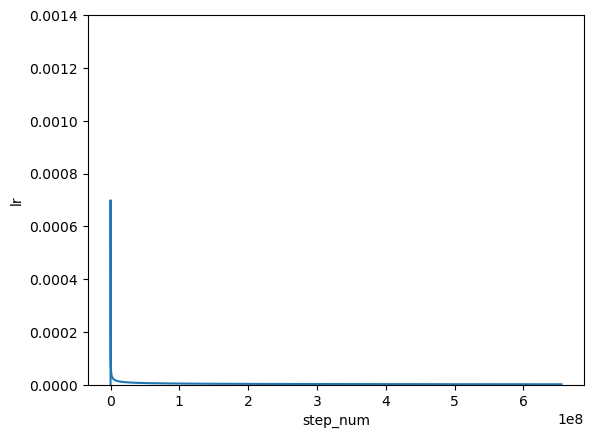

In [19]:
import numpy as np
import matplotlib.pyplot as plt

warmup_steps = 4000
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.5
warmup_steps_exp = -1.5
dim_embedding_exp = -0.5
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.xlabel('step_num')
plt.ylabel('lr')
plt.ylim(0, 0.0014)
plt.show()

Como se puede ver sube muy rápido y luego baja muy rápido a un valor tan pequeño que es casi como si no hubiera learning rate. Por lo que los pesos de la red neuronal apenas se van a actualizar. Por lo que probando voy a usar esta fórmula

$$lr = d_{model}^{-0.1} \cdot min \left(stepNumber^{-0.4}, stepNumber \cdot stepWarmUp^{-2.6} \right)$$

Con lo que el learning rate evolucionaría así

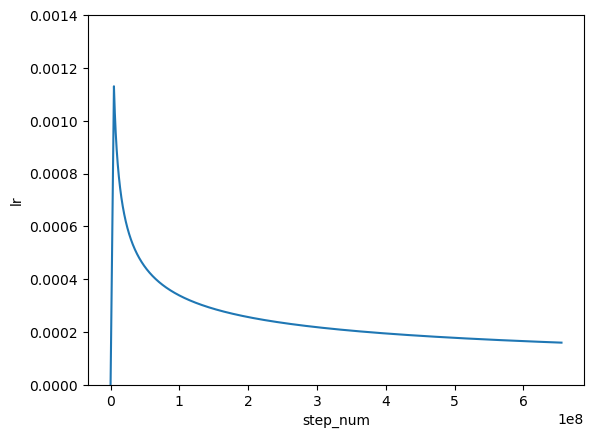

In [20]:
warmup_steps = 4000
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.4
warmup_steps_exp = -2.6
dim_embedding_exp = -0.1
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.xlabel('step_num')
plt.ylabel('lr')
plt.ylim(0, 0.0014)
plt.show()

In [21]:
def calculate_lr(step_num, dim_embeding_model=512, warmup_steps=4000):
    step_num += 1e-7 # Avoid division by zero
    step_num += STEP0
    actual_step.set_step(step_num)
    step_num_exp = -0.4
    warmup_steps_exp = -2.6
    dim_embeding_model_exp = -0.1
    lr = np.power(dim_embeding_model, dim_embeding_model_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))
    actual_lr.set_lr(lr)
    return lr

lr_lambda = lambda step: calculate_lr(step, dim_embeding_model=dim_embedding)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Ciclo de entrenamiento

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer, device, mask, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    mean_loss = 0
    lr_list = []
    for batch, (src, trg) in enumerate(dataloader):
        src = src.to(device)
        trg = trg.to(device)
        mask = mask.to(device)

        pred = model(src, trg, mask)
        loss = loss_fn(pred.transpose(1, 2), trg)
        mean_loss += loss.item()

        # lr = optimizer.param_groups[0]['lr']
        lr = actual_lr.get_lr()
        lr_list.append(lr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(src)
            print(f"loss: {loss:0.10f} [{current:>5d}/{size:>5d}] - epoch {epoch} - lr {lr}")
    return mean_loss/num_batches, np.array(lr_list)

def validation_loop(dataloader, model, loss_fn, device, mask):
    num_batches = len(dataloader)
    validation_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)
            mask = mask.to(device)

            pred = model(src, trg, mask)
            validation_loss += loss_fn(pred.transpose(1, 2), trg).item()
    validation_loss /= num_batches
    print(f"Avg validation loss: {validation_loss:>8f}")
    return validation_loss


In [23]:
# Device
if torch.cuda.device_count() > 1 and GPUS > 1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.device_count()} GPUs")
else:
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{GPU_NUMBER}")
        print(f"Using GPU {GPU_NUMBER}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

transformer = transformer.to(device)

Using 2 GPUs


Creamos una función que calcula el tiempo transcurrido

In [24]:
def elapsed_time(t0):
    t = time.time() - t0  # tiempo transcurrido en segundos

    # Convertir el tiempo a días, horas, minutos y segundos
    days, t = divmod(t, 86400)  # 86400 segundos en un día
    hours, t = divmod(t, 3600)  # 3600 segundos en una hora
    minutes, seconds = divmod(t, 60)  # 60 segundos en un minuto

    return int(days), int(hours), int(minutes), int(seconds)

def elapsed_seconds(days, hours, minutes, seconds):
    return days * 86400 + hours * 3600 + minutes * 60 + seconds


Cargamos los pesos si no partimos desde cero

In [25]:
if EPOCH0 != 0 or STEP0 != 0:
    if GPUS > 1:
        print(f"Loading model from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")
        transformer.load_state_dict(torch.load(f'{MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth'))
        print(f"Model loaded from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")
    else:
        print(f"Loading model from {MODEL_PATH}/transformer_model_{EPOCH0}_{STEP0}.pth")
        weights = f"{MODEL_PATH}/transformer_model_{EPOCH0}_{STEP0}.pth"
        transformer = torch.load(weights, map_location=device)
        if isinstance(transformer, nn.DataParallel):
            print("Transforming model to nn.Module")
            transformer = transformer.module
        print(f"Model loaded from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")

    print(f"load best validation loss from {MODEL_PATH}/best_validation_loss_{EPOCH0}_{STEP0}.npy")
    best_loss = np.load(f'{MODEL_PATH}/validation_loss_{EPOCH0}_{STEP0}.npy')
    print(f"best validation loss: {best_loss}")
else:
    best_loss = 1000000


Creamos listas donde se guardarán los valores de pérdida y learning rate

In [26]:
train_loss_list = []
train_lr_list = []
validation_loss_list = []
train_loss_list = np.array(train_loss_list)
train_lr_list = np.array(train_lr_list)
validation_loss_list = np.array(validation_loss_list)

In [27]:
import os

best_loss = 1000000
max_seconds = 60*60*11 + 60*30 # 11 horas y 30 minutos

for epoch in range(EPOCH0, EPOCHS, 1):
    days, hours, minutes, seconds = elapsed_time(t0)
    print(f"\nEpoch {epoch}\n-------------------------------, {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")
    train_loss, train_lr = train_loop(train_dataloader, transformer, loss_function, optimizer, device, mask, epoch)
    validation_loss = validation_loop(validation_dataloader, transformer, loss_function, device, mask)

    train_loss_list = np.append(train_loss_list, train_loss)
    train_lr_list = np.append(train_lr_list, train_lr)
    validation_loss_list = np.append(validation_loss_list, validation_loss)

    if validation_loss < best_loss:
        best_loss = validation_loss
        if not os.path.exists(MODEL_PATH):
            os.makedirs(MODEL_PATH)
        # Delete all files in folder
        files = os.listdir(MODEL_PATH)
        for f in files:
            os.remove(os.path.join(MODEL_PATH, f))
        torch.save(transformer.state_dict(), f'{MODEL_PATH}/transformer_{epoch+1}_{actual_step.get_step()}.pth')
        torch.save(transformer, f'{MODEL_PATH}/transformer_model_{epoch+1}_{actual_step.get_step()}.pth')
        val = np.array([validation_loss])
        np.save(f'{MODEL_PATH}/validation_loss_{epoch+1}_{actual_step.get_step()}.npy', val)
        print(f"Best model saved with loss {best_loss} at epoch {epoch}, in {time.time()-t0} ms, with lr {train_lr[-1]} and in step {actual_step.get_step()} --> {MODEL_PATH}/transformer_{epoch+1}_{actual_step.get_step()}.pth")

    days, hours, minutes, seconds = elapsed_time(t0)
    train_elapsed_seconds = elapsed_seconds(days, hours, minutes, seconds)
    if train_elapsed_seconds > max_seconds:
        print("Time out!")
        break

np.save(f'{MODEL_PATH}/train_loss_list.npy', train_loss_list)
np.save(f'{MODEL_PATH}/train_lr_list.npy', train_lr_list)
np.save(f'{MODEL_PATH}/validation_loss_list.npy', validation_loss_list)

print("Done!")


Epoch 0
-------------------------------, 0 days, 0 hours, 0 minutes, 15 seconds
loss: 0.0002542284 [    0/983138] - epoch 0 - lr 2.3105588072317385e-17
loss: 0.0002566822 [15000/983138] - epoch 0 - lr 2.310558809542297e-08


KeyboardInterrupt: 

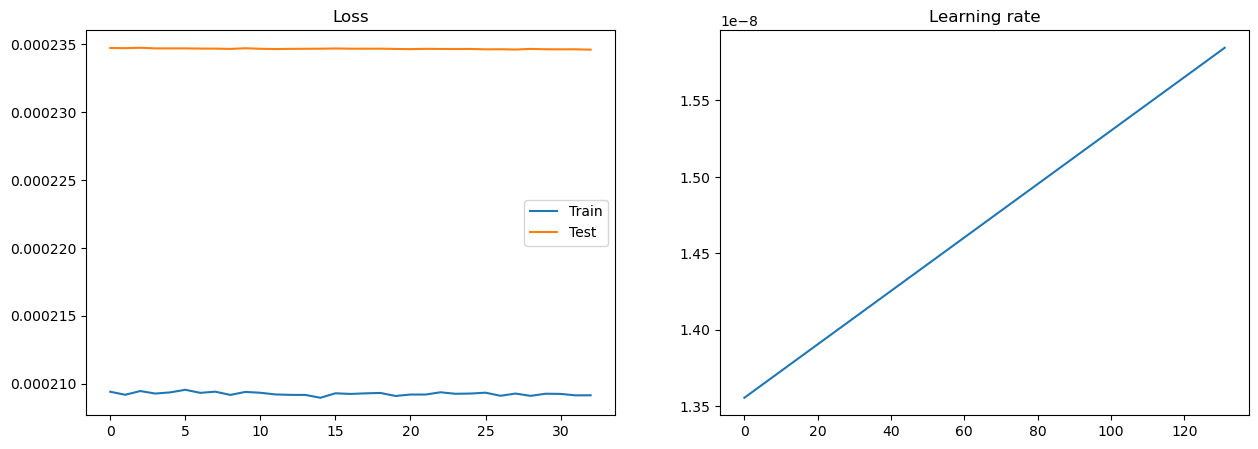

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_list)
axs[0].plot(validation_loss_list)
axs[0].set_title("Loss")
axs[0].legend(["Train", "Test"])
axs[1].plot(train_lr_list)
axs[1].set_title("Learning rate")
plt.show()